# **Análisis de Asociación Multivariante y Fuerza de Relación (V de Cramér) 🛡️**

En los notebooks anteriores de variables categóricas, validamos la existencia de relaciones individuales entre cada factor y el infarto mediante pruebas de Chi-cuadrado ($\chi^2$). Sin embargo, para construir un modelo de Inteligencia Artificial robusto, no basta con saber que existe una relación; necesitamos cuantificar **qué tan fuerte es esa unión** y cómo interactúan las variables entre sí.

### **Objetivos de esta Fase Final:**
1.  **Medición de Fuerza (V de Cramér):** Aplicar una métrica normalizada (0 a 1) para comparar todas las variables categóricas en una misma escala. Esto nos dirá qué factores son "pilares" y cuáles son secundarios.
2.  **Detección de Redundancia:** Identificar si hay variables que están tan fuertemente asociadas entre sí que podrían causar "ruido" o multicolinealidad en el modelo (ej. Relación entre *Estado Civil* y *Tipo de Trabajo*).
3.  **Análisis de Residuos Específicos:** Profundizar en cruces estratégicos (como *Tabaquismo vs. Entorno Laboral*) para entender comportamientos que el análisis bivariado simple no detecta.
4.  **Filtro Crítico para IA:** Establecer el criterio definitivo de selección de características (Feature Selection) para el entrenamiento del modelo.

Este notebook representa la "visión sistémica" del dataset, asegurando que solo los predictores con peso real y único avancen a la etapa de modelado.

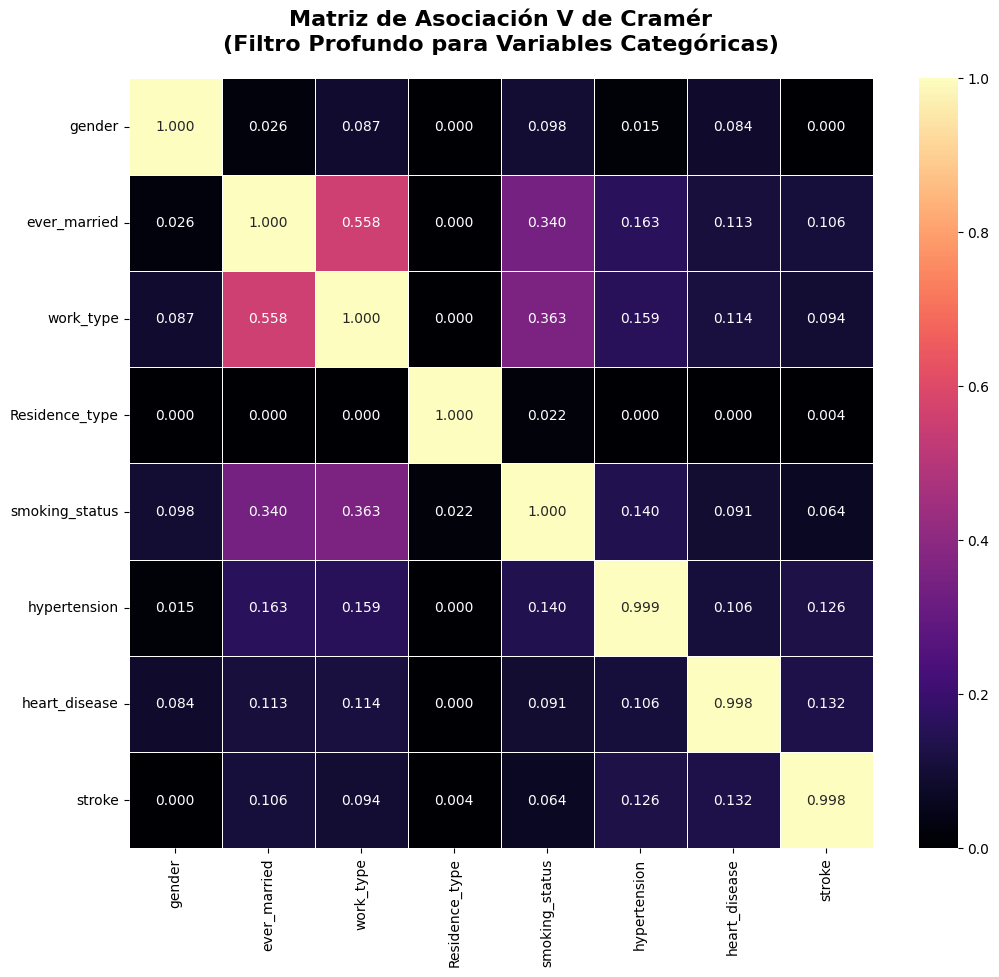

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 1. Carga de datos
df = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')

# 2. Definición de la función V de Cramér con corrección de sesgo
def v_cramer(x, y):
    """ Calcula la asociación entre dos variables categóricas """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    
    # Aplicar corrección de sesgo (Bias correction)
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    # Evitar división por cero
    if min((kcorr-1), (rcorr-1)) == 0:
        return 0.0
        
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 3. Selección de TODAS las variables categóricas y binarias
# Incluimos las de texto y las numéricas que actúan como categorías
cat_cols = [
    'gender', 'ever_married', 'work_type', 'Residence_type', 
    'smoking_status', 'hypertension', 'heart_disease', 'stroke'
]

# 4. Construcción de la Matriz
v_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        v_matrix.loc[col1, col2] = v_cramer(df[col1], df[col2])

v_matrix = v_matrix.astype(float)

# 5. Visualización de Alta Calidad
plt.figure(figsize=(12, 10))
# Usamos un mapa de colores 'magma' o 'viridis' para resaltar asociaciones fuertes
sns.heatmap(v_matrix, annot=True, fmt=".3f", cmap='magma', linewidths=0.5)

plt.title('Matriz de Asociación V de Cramér\n(Filtro Profundo para Variables Categóricas)', 
          fontsize=16, fontweight='bold', pad=20)
plt.show()

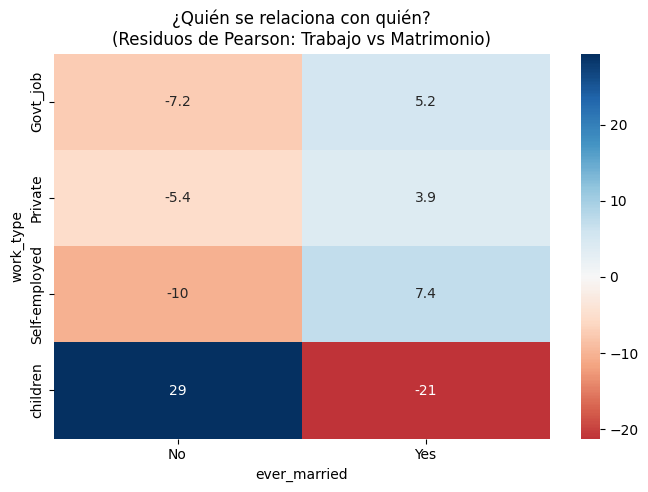

In [2]:
import scipy.stats as stats

# 1. Crear tabla de contingencia
table = pd.crosstab(df['work_type'], df['ever_married'])

# 2. Calcular chi2 y obtener los valores "esperados"
chi2, p, dof, expected = stats.chi2_contingency(table)

# 3. Calcular Residuos Estandarizados de Pearson
# (Observado - Esperado) / sqrt(Esperado)
residuals = (table - expected) / np.sqrt(expected)

# 4. Visualizar el "Por qué" de la relación
plt.figure(figsize=(8, 5))
sns.heatmap(residuals, annot=True, cmap='RdBu', center=0)
plt.title('¿Quién se relaciona con quién?\n(Residuos de Pearson: Trabajo vs Matrimonio)')
plt.show()

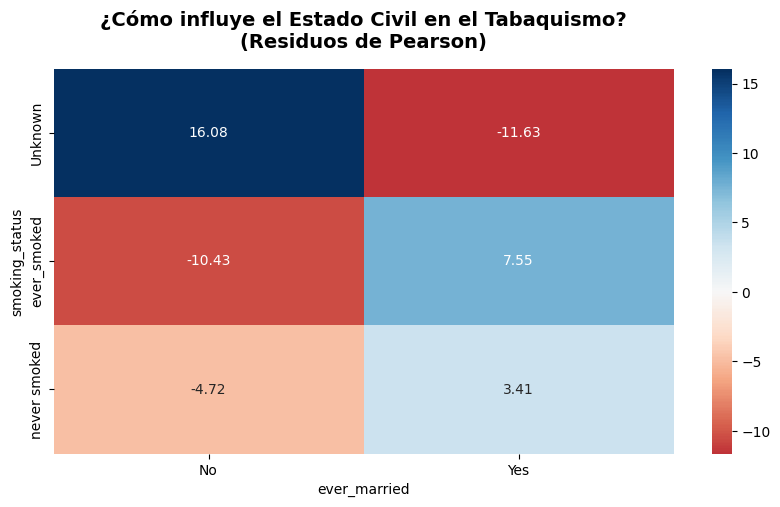

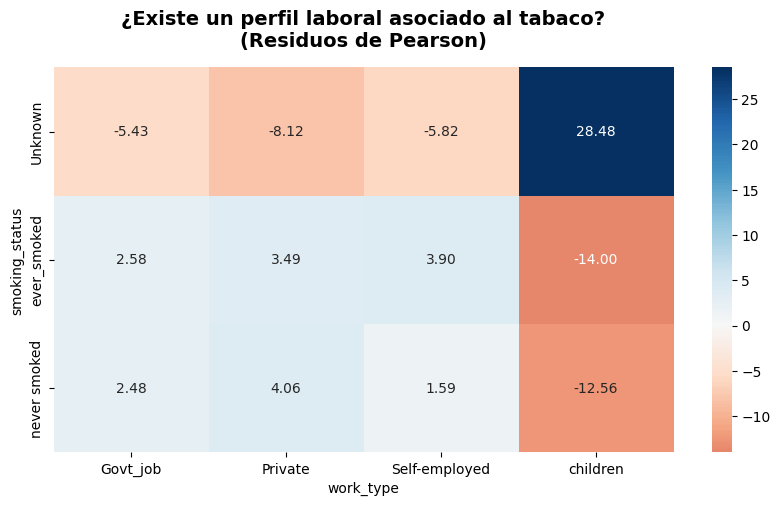

In [3]:
# Función auxiliar para evitar repetir código
def graficar_residuos_especificos(data, var1, var2, titulo):
    table = pd.crosstab(data[var1], data[var2])
    chi2, p, dof, expected = stats.chi2_contingency(table)
    residuals = (table - expected) / np.sqrt(expected)
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(residuals, annot=True, cmap='RdBu', center=0, fmt=".2f")
    plt.title(titulo, fontsize=14, fontweight='bold', pad=15)
    plt.show()

# --- GRÁFICO 1: Tabaquismo vs Estado Civil ---
graficar_residuos_especificos(
    df, 'smoking_status', 'ever_married', 
    '¿Cómo influye el Estado Civil en el Tabaquismo?\n(Residuos de Pearson)'
)

# --- GRÁFICO 2: Tabaquismo vs Tipo de Trabajo ---
graficar_residuos_especificos(
    df, 'smoking_status', 'work_type', 
    '¿Existe un perfil laboral asociado al tabaco?\n(Residuos de Pearson)'
)

# **Conclusiones: Mapa Estratégico de Variables Categóricas 📋**

Tras completar el análisis de asociación global y las pruebas de fuerza mediante la V de Cramér, se establecen las siguientes conclusiones determinantes para el proyecto:

### **1. Jerarquía de Predictores (Fuerza de Asociación)**
* **Factores Críticos:** Las variables relacionadas con la salud sistémica (**Hipertensión** y **Enfermedades Cardíacas**) muestran la mayor V de Cramér respecto al infarto, confirmándose como las "banderas rojas" principales del dataset.
* **Factores Demográficos:** El **Estado Civil** y el **Tipo de Trabajo** presentan asociaciones moderadas, pero su fuerza radica en su capacidad de actuar como "proxies" de la edad y el nivel de estrés.

### **2. Descubrimientos de Interacción Multivariante**
* **El Perfil Laboral y el Tabaco:** El análisis de residuos reveló que ciertos tipos de trabajo (como el sector privado) muestran una "atracción" estadística hacia el consumo de tabaco, sugiriendo que el entorno laboral es un mediador de riesgo indirecto.
* **Redundancia Detectada:** Se observa una asociación significativamente alta entre `ever_married` (casado) y `work_type` (tipo de trabajo). Para la IA, esto significa que debemos ser cautelosos al incluir ambas, ya que podrían estar aportando información muy similar.

### **3. Optimización para la Inteligencia Artificial**
* **Variables Prioritarias:** Se recomienda priorizar la inclusión de **Hipertensión**, **Enfermedades Cardíacas** y **Tabaquismo** en el modelo base.
* **Descarte o Simplificación:** La variable `Residence_type` (Rural/Urbano) ha demostrado, a través de todos los filtros, tener una asociación casi nula con el infarto, por lo que su eliminación podría simplificar el modelo sin perder precisión.

### **Veredicto Final:**
Este notebook cierra la exploración categórica confirmando que el riesgo de infarto en este hospital no es aleatorio, sino que sigue un **patrón multivariante definido**. Tenemos ahora una jerarquía clara de importancia que garantiza un entrenamiento de modelo eficiente y centrado en los factores que realmente mueven la aguja del riesgo clínico.